# NEMO User's Guide: a Jupyter notebook

Note that this is a Jupyter notebook that uses some magic IPython commands (starting with %). It may not work in other notebooks like the one included with Pycharm.

## Installing a configuration file

Before you can run NEMO, __you need a configuration file__. The default configuration file (`nemo.cfg`) is installed with the NEMO package and can be copied into your working directory as a starting point. On Unix systems, this can be found at `/usr/local/etc/nemo.cfg`. Alternatively, you can set the `NEMORC` environment variable to point to a configuration file. See the "Configuration file" section below for more details on the format of this file.

## A simple example

NEMO can be driven by your own Python code.  Some simple examples of how to do this appear below.  First, we will create a simulation with a single combined cycle gas turbine (CCGT). The "NSW1:31" notation indicates that the generator is sited in polygon 31 in the NSW1 region.

In [2]:
import nemo
from nemo import scenarios
c = nemo.Context()
scenarios._one_ccgt(c)
print(c.generators)

[CCGT (NSW1:31), 0.00 MW]


Then run the simulation:

In [3]:
nemo.run(c)
print(c)

Timesteps: 8760 h
Demand energy: 204.37 TWh
Unused surplus energy: 0.00 MWh
Unserved energy: 100.000%
Unserved total hours: 8760
Number of unserved energy events: 1
Shortfalls (min, max): (15.47 GW, 33.65 GW)


The CCGT is configured with a zero capacity. Hence, no electricity is served in the simulation (100% unserved energy) and the largest shortfall was 33,645 MW (33.6 GW). This figure corresponds to the peak demand in the simulated year.

Let's now do a run with the default scenario (two CCGTs: 13.2 GW and 20 GW, respectively) such that almost of the demand is met except for a few hours of unserved energy:

In [4]:
c = nemo.Context()
c.generators[0].set_capacity(13.2)
c.generators[1].set_capacity(20)
nemo.run(c)
print(c)

Timesteps: 8760 h
Demand energy: 204.37 TWh
Unused surplus energy: 0.00 MWh
Unserved energy: 0.001%
Unserved total hours: 6
Number of unserved energy events: 2
Shortfalls (min, max): (88.36 MW, 445.14 MW)


If we print the `unserved` attribute in the context, we can see when the six hours of unserved energy occurred and how large the shortfalls were:

In [4]:
print(c.unserved)

Date_Time
2010-01-11 13:00:00     88.360
2010-01-11 14:00:00    245.200
2010-01-11 15:00:00    445.140
2010-01-11 16:00:00    113.530
2010-01-12 13:00:00    245.860
2010-01-12 14:00:00    178.365
dtype: float64


## Plotting results

NEMO includes a `utils.py` module that includes a `plot` function to show the time sequential dispatch. The following example demonstrates its use:

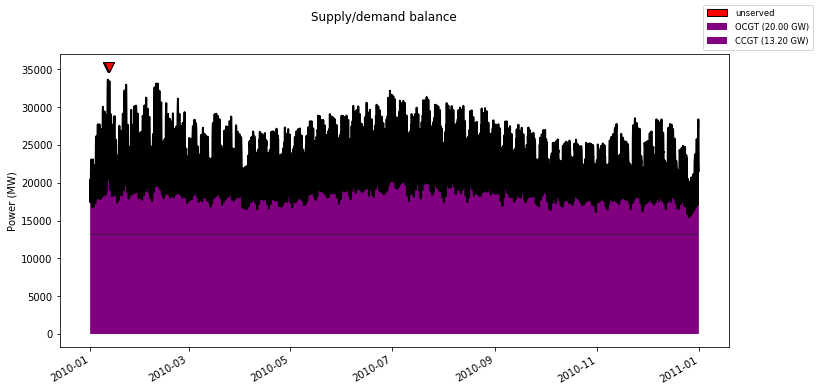

In [5]:
from matplotlib.pyplot import ioff
from nemo import utils
ioff()
utils.plt.rcParams["figure.figsize"] = (12, 6)  # 12" x 6" figure
utils.plot(c)

The previous plot is rather bunched up. Instead, you can also pass a pair of dates to the `plot()` function to limit the range of dates shown. For example:

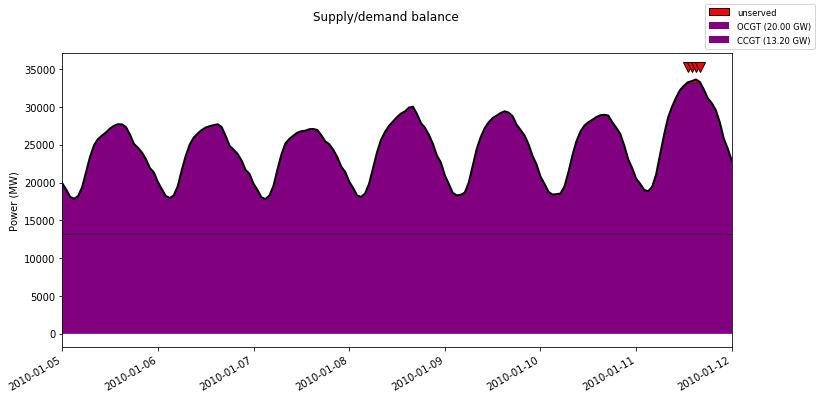

In [6]:
from matplotlib.pyplot import ioff
from datetime import datetime
ioff()
utils.plt.rcParams["figure.figsize"] = (12, 6)  # 12" x 6" figure
utils.plot(c, xlim=[datetime(2010, 1, 5), datetime(2010, 1, 12)])

## Scripting simulations 

Writing NEMO in Python allows the simulation framework to be easily scripted using Python language constructs, such as for loops. Using the previous example, the following small script demonstrates how simulation runs can be automated:

In [7]:
c = nemo.Context()
scenarios._one_ccgt(c)
for i in range(0, 40):
    c.generators[0].set_capacity(i)
    nemo.run(c)
    if c.unserved_energy() == 0:
        break
print(c.generators)

[CCGT (NSW1:31), 34000.00 MW]


Once the generator capacity reaches 34 GW, there is no unserved energy.

## Scenarios

NEMO contains two types of scenarios: supply-side and demand-side scenarios. The supply-side scenario modifies the list of generators. For example:

In [8]:
c = nemo.Context()
scenarios.ccgt(c)
print(c.generators)

[CCGT (NSW1:31), 0.00 MW, poly 17 pumped-hydro (QLD1:17), 500.00 MW, poly 36 pumped-hydro (NSW1:36), 1740.00 MW, poly 24 hydro (NSW1:24), 42.50 MW, poly 31 hydro (NSW1:31), 43.00 MW, poly 35 hydro (NSW1:35), 71.00 MW, poly 36 hydro (NSW1:36), 2513.90 MW, poly 38 hydro (VIC1:38), 450.00 MW, poly 39 hydro (VIC1:39), 13.80 MW, poly 40 hydro (TAS1:40), 586.60 MW, poly 41 hydro (TAS1:41), 280.00 MW, poly 42 hydro (TAS1:42), 590.40 MW, poly 43 hydro (TAS1:43), 462.50 MW, OCGT (NSW1:31), 0.00 MW]


A list of the current supply-side scenarios (with descriptions) can be obtained by running `evolve --list-scenarios` from the shell (without the leading !):

In [9]:
!python3 evolve --list-scenarios

        __one_ccgt__ 	 One CCGT only.
                ccgt 	 All gas scenario.
            ccgt-ccs 	 CCGT CCS scenario.
            coal-ccs 	 Coal CCS scenario.
              re+ccs 	 Mostly renewables with fossil and CCS augmentation.
           re+fossil 	 Mostly renewables with some fossil augmentation.
               re100 	 100% renewable electricity.
     re100+batteries 	 Use lots of renewables plus battery storage.
           re100+dsp 	 Mostly renewables with demand side participation.
         re100-nocst 	 100% renewables, but no CST.
           re100-nsw 	 100% renewables in New South Wales only.
           re100-qld 	 100% renewables in Queensland only.
            re100-sa 	 100% renewables in South Australia only.
         replacement 	 Replace the current NEM fleet, more or less.


Demand-side scenarios modify the electricity demand time series before the simulation runs. Demand-side scenarios behave like operators that can be combined in any combination to modify the demand as desired. These are:

   * roll:X rolls the load by x timesteps
   * scale:X scales the load by x percent
   * scaletwh:X scales the load to x TWh
   * shift:N:H1:H2 shifts n megawatts every day from hour h1 to hour h2
   * peaks:N:X adjust demand peaks over n megawatts by x percent
   * npeaks:N:X adjust top n demand peaks by x percent

For example, applying `scale:-10` followed by `shift:1000:16:12` will reduce the overall demand by 10% and then shift 1 MW of demand from 4pm to noon every day of the year.

## Configuration file

NEMO uses a configuration file to give users control over where data such as demand time series are to be found. The location of the configuration file can be specified by setting the NEMORC environment variable. The configuration file format is similar to Windows INI files; it has sections (in brackets) and, within sections, key=value pairs.

The default configuration file is called `nemo.cfg`. The keys currently recognised are:

  * [costs]
  *  *  co2-price-per-t
  *  *  ccs-storage-costs-per-t
  *  *  coal-price-per-gj
  *  *  discount-rate -- as a fraction (eg 0.05)
  *  *  gas-price-per-gj
  *  *  technology-cost-class -- default cost class
  * [limits]
  *  *  hydro-twh-per-yr
  *  *  bioenergy-twh-per-yr
  *  *  nonsync-penetration -- as a fraction (eg 0.75)
  *  *  minimum-reserves-mw
  * [optimiser]
  *  *  generations -- number of CMA-ES generations to run
  *  *  sigma -- initial step-size
  * [generation]
  *  *  cst-trace -- URL of CST generation traces
  *  *  egs-geothermal-trace -- URL of EGS geothermal generation traces
  *  *  hsa-geothermal-trace -- URL of HSA geothermal generation traces
  *  *  wind-trace -- URL of wind generation traces
  *  *  pv1axis-trace -- URL of 1-axis PV generation traces
  *  *  rooftop-pv-trace -- URL of rooftop PV generation traces
  *  *  offshore-wind-trace -- URL of offshore wind generation traces
  * [demand]
  *  *  demand-trace -- URL of demand trace data

## Running an optimisation

Instead of running a single simulation, it is more interesting to use `evolve` which drives an evolutionary algorithm to find the least cost portfolio that meets demand. There are many options which you can discover by running `evolve --help`. Here is a simple example to find the least cost portfolio using the `ccgt` scenario (all-gas scenario with CCGT and OCGT generation):

`$ evolve -s ccgt`

It is possible to distribute the workload across multiple CPUs and multiple computers. See the [SCOOP](http://scoop.readthedocs.io/en/0.7/usage.html#how-to-launch-scoop-programs) documentation for more details. To run the same evolution, but using all of your locally available CPU cores, you need to load the SCOOP module like so:

`$ python3 -m scoop evolve -s ccgt`

At the end of a run, details of the least cost system are printed on the console: the capacity of each generator, the energy supplied, CO2 emissions, costs, and the average cost of generation in dollars per MWh.  If you want to see a plot of the system dispatch, you need to use the `replay.py` script described in the next section.

Many of the optimisation parameters can be controlled from the command line, requiring no changes to the source code. Typically, source code changes are only required to add [new supply scenario functions](https://git.ozlabs.org/?p=nemo.git;a=blob;f=scenarios.py;hb=HEAD) or [cost classes](https://git.ozlabs.org/?p=nemo.git;a=blob;f=costs.py;hb=HEAD). The command line options for `evolve` are documented as follows:

| Short option | Long option | Description                                  | Default |
|--------------|-------------|----------------------------------------------|---------|
| -h | --help                | Show help and then exit                      |         |
| -c | --carbon-price        | Carbon price in \$/tonne                     | 25      |
| -d | --demand-modifier     | Demand modifier                              | unchanged |
| -g | --generations         | Number of generations to run                 | 100     |
| -o | --output              | Filename of results output file (will overwrite) | results.json |
| -p | --plot                | Plot an hourly energy balance on completion  |         |
| -r | --discount-rate       | Discount rate                                | 0.05    |
| -s | --supply-scenario     | Generation mix scenario                      | `re100` |
| -v | --verbose             | Be verbose                                   | False   |
|    | --bioenergy-limit     | Limit on annual energy from bioenergy in TWh/year | 20 |
|    | --ccs-storage-costs   | CCS storage costs in \$/tonne                | 27      |
|    | --coal-price          | Coal price in \$/GJ                          | 1.86    |
|    | --costs               | Use different cost scenario                  | AETA2013-in2030-mid |
|    | --emissions-limit     | Limit total emissions to N Mt/year           | $\infty$ |
|    | --fossil-limit        | Limit share of energy from fossil sources    | 1.0  |
|    | --gas-price           | Gas price in \$/GJ                           | 11   |
|    | --hydro-limit         | Limit on annual energy from hydro in TWh/year| 12   |
|    | --lambda              | CMA-ES lambda value                          | None (autodetect) |
|    | --list-scenarios      | Print list of scenarios and exit             |      |
|    | --min-regional-generation | Minimum share of energy generated intra-region | 0.0
|    | --nsp-limit           | Non-synchronous penetration limit            | 0.75 |
|    | --reliability-std     | Reliability standard (% unserved)            | 0.002 |
|    | --seed                | Seed for random number generator             | None |
|    | --sigma               | CMA-ES sigma value                           | 2.0  |
|    | --trace-file          | Filename for evaluation trace                | None |
|    | --version             | Print version number and exit                |      |

## Replaying a simulation

To avoid having to re-run a long optimisation just to examine the resulting system, it is possible to reproduce a single run using the results from an earlier optimisation. The `evolve` script writes an output file at the end of the run (default filename `results.json`).  This file encodes all of the relevant information from the optimisation run so that the solution it found can be replayed easily and accurately by `replay`.

The input file for `replay` may consist of any number of scenarios and configurations to replay, one per line. Blank lines are ignored and comment lines (`#`) are shown for information. Each non-comment line must contain a JSON record from the results file that `evolve` writes. Typically the input file for `replay` will just be the output file from `evolve` unmodified. However, if you want multiple simulations to be replayed, this is easy to achieve by pasting multiple JSON strings into the file, one per line.

A run is replayed using `replay` like so:

`$ replay -f results.json -p`

The `-f` option specifies the name of the input data file (the default is `results.json`) and the `-p` option enables a graphical plot of the system dispatch that you can navigate using zoom in, zoom out and pan controls. By including the `--spills` option, surplus energy in each hour will be plotted above the demand line in a lighter shade than the usual colour of the spilling generator.  All command line options can be displayed using:

In [2]:
!python3 replay --help

usage: replay [-h] [-f FILE] [-p] [-v] [--spills] [--no-legend]

Bug reports via via https://nemo.ozlabs.org

optional arguments:
  -h, --help   show this help message and exit
  -f FILE      filename of results file
  -p, --plot   plot an energy balance
  -v           verbosity level
  --spills     plot surplus generation
  --no-legend  hide legend


## Summarising the optimiser output

NEMO includes an [AWK](https://en.wikipedia.org/wiki/AWK) script called `summary.awk` that processes the verbose output from `evolve` and summarises it in a convenient table. You can either pipe the `evolve` output directly into `summary.awk` (as below) or you can save the `evolve` output into a text file and use shell redirection to read the file as input. An example of piping:

In [3]:
!python3 evolve -s ccgt -g10 | awk -f summary.awk

# scenario 1
# options {'demand_modifier': None, 'list_scenarios': False, 'output': 'results.json', 'reliability_std': 0.002, 'reserves': 0, 'supply_scenario': 'ccgt', 'carbon_price': 25, 'costs': 'AETA2013-in2030-mid', 'ccs_storage_costs': 27.0, 'coal_price': 1.86, 'gas_price': 11.0, 'discount_rate': 0.05, 'bioenergy_limit': 20.0, 'emissions_limit': inf, 'fossil_limit': 1.0, 'hydro_limit': 12.0, 'min_regional_generation': 0.0, 'nsp_limit': 0.75, 'lambda_': None, 'seed': None, 'sigma': 2.0, 'generations': 10, 'trace_file': None, 'verbose': False}
# demand 204.37 TWh
# emissions 79.70 Mt
# unserved 
# score 100.91 $/MWh
#       tech	  GW	share	  TWh	share	CF
        CCGT	24.9	0.652	198.2	0.970	0.908
       hydro	 3.7	0.096	  5.6	0.028	0.175
         PSH	 1.5	0.038	  0.0	0.000	0.001
        OCGT	 8.2	0.214	  0.5	0.003	0.007

